# Dataset Overview
I will be looking at several differents texts, all from different authors. The goal is classification by author using a variety of different methods, including supervised/unsupervised learning techniques and NLP feature engineering.

In [159]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import gutenberg, stopwords
from collections import Counter
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation
from sklearn import metrics
from itertools import cycle
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

# Cleaning, Processing and Parsing

In [56]:
print(gutenberg.fileids())

['austen-emma.txt', 'austen-persuasion.txt', 'austen-sense.txt', 'bible-kjv.txt', 'blake-poems.txt', 'bryant-stories.txt', 'burgess-busterbrown.txt', 'carroll-alice.txt', 'chesterton-ball.txt', 'chesterton-brown.txt', 'chesterton-thursday.txt', 'edgeworth-parents.txt', 'melville-moby_dick.txt', 'milton-paradise.txt', 'shakespeare-caesar.txt', 'shakespeare-hamlet.txt', 'shakespeare-macbeth.txt', 'whitman-leaves.txt']


In [63]:
#Load the raw text
austen = gutenberg.raw('austen-emma.txt')
blake = gutenberg.raw('blake-poems.txt')
bryant = gutenberg.raw('bryant-stories.txt')
burgess = gutenberg.raw('burgess-busterbrown.txt')
carroll = gutenberg.raw('carroll-alice.txt')
chesterton = gutenberg.raw('chesterton-brown.txt')
edgeworth = gutenberg.raw('edgeworth-parents.txt')
melville = gutenberg.raw('melville-moby_dick.txt')
milton = gutenberg.raw('milton-paradise.txt')
whitman = gutenberg.raw('whitman-leaves.txt')

#Create list of texts
texts = [austen, blake, bryant, burgess, carroll, chesterton, edgeworth, melville, milton, whitman]

**Inspect Raw Files**

In [64]:
for i in texts:
    print(i[0:200])

[Emma by Jane Austen 1816]

VOLUME I

CHAPTER I


Emma Woodhouse, handsome, clever, and rich, with a comfortable home
and happy disposition, seemed to unite some of the best blessings
of existence; an
[Poems by William Blake 1789]

 
SONGS OF INNOCENCE AND OF EXPERIENCE
and THE BOOK of THEL


 SONGS OF INNOCENCE
 
 
 INTRODUCTION
 
 Piping down the valleys wild,
   Piping songs of pleasant glee,
 O
[Stories to Tell to Children by Sara Cone Bryant 1918] 


TWO LITTLE RIDDLES IN RHYME


     There's a garden that I ken,
     Full of little gentlemen;
     Little caps of blue they wear,
  
[The Adventures of Buster Bear by Thornton W. Burgess 1920]

I

BUSTER BEAR GOES FISHING


Buster Bear yawned as he lay on his comfortable bed of leaves and
watched the first early morning sun
[Alice's Adventures in Wonderland by Lewis Carroll 1865]

CHAPTER I. Down the Rabbit-Hole

Alice was beginning to get very tired of sitting by her sister on the
bank, and of having nothing to do: once
[The Wisdom 

** Clean and Process the Texts **

In [67]:
# Utility function for standard text cleaning.
def text_cleaner(text):
    text = re.sub(r'--',' ',text)
    text = re.sub("[\[].*?[\]]", "", text)
    text = re.sub("\d+", "", text)
    text = re.sub(r'Chapter \d+', '', text)
    text = re.sub(r'VOLUME \w+', '', text)
    text = re.sub(r'CHAPTER \w+', '', text)
    text = re.sub(r'BOOK \w+', '', text)
    text = ' '.join(text.split())
    return text

In [80]:
#Clean each text
austen = text_cleaner(austen)
blake = text_cleaner(blake)
bryant = text_cleaner(bryant)
burgess = text_cleaner(burgess)
carroll = text_cleaner(carroll)
chesterton = text_cleaner(chesterton)
edgeworth = text_cleaner(edgeworth)
melville = text_cleaner(melville)
milton = text_cleaner(milton)
whitman = text_cleaner(whitman)

** Parse the Texts **

In [91]:
for i in texts:
    print(len(i))

887071
38153
249439
84663
144395
406629
935158
1242990
468220
711215


In [86]:
#Parse the cleaned texts
nlp = spacy.load('en')

#Due to memory limitations, reduce size to less than 1 mil
melville = melville[0:999999]

In [101]:
#Run NLP on each text
austen_doc = nlp(austen)
blake_doc = nlp(blake)
bryant_doc = nlp(bryant)
burgess_doc = nlp(burgess)
carroll_doc = nlp(carroll)
chesterton_doc = nlp(chesterton)
edgeworth_doc = nlp(edgeworth)
melville_doc = nlp(melville)
milton_doc = nlp(milton)
whitman_doc = nlp(whitman)

In [102]:
# Group into sentences.
austen_sents = [[sent, "Austen"] for sent in austen_doc.sents]
blake_sents = [[sent, "Blake"] for sent in blake_doc.sents]
bryant_sents = [[sent, "Bryant"] for sent in bryant_doc.sents]
burgess_sents = [[sent, "Burgess"] for sent in burgess_doc.sents]
carroll_sents = [[sent, "Carroll"] for sent in carroll_doc.sents]
chesterton_sents = [[sent, "Chesterton"] for sent in chesterton_doc.sents]
edgeworth_sents = [[sent, "Edgeworth"] for sent in edgeworth_doc.sents]
melville_sents = [[sent, "Melville"] for sent in melville_doc.sents]
milton_sents = [[sent, "Milton"] for sent in milton_doc.sents]
whitman_sents = [[sent, "Whitman"] for sent in whitman_doc.sents]

print(len(austen_sents))
print(len(blake_sents))
print(len(bryant_sents))
print(len(burgess_sents))
print(len(carroll_sents))
print(len(chesterton_sents))
print(len(edgeworth_sents))
print(len(melville_sents))
print(len(milton_sents))
print(len(whitman_sents))

8905
497
2779
1013
1678
3716
10208
8027
2765
5531


In [104]:
#For computational purposes, reduce length of each set of sentences to 500
austen_sents = austen_sents[0:200]
blake_sents = blake_sents[0:200]
bryant_sents = bryant_sents[0:200]
burgess_sents = burgess_sents[0:200]
carroll_sents = carroll_sents[0:200]
chesterton_sents = chesterton_sents[0:200]
edgeworth_sents = edgeworth_sents[0:200]
melville_sents = melville_sents[0:200]
milton_sents = milton_sents[0:200]
whitman_sents = whitman_sents[0:200]

print(len(austen_sents))
print(len(blake_sents))
print(len(bryant_sents))
print(len(burgess_sents))
print(len(carroll_sents))
print(len(chesterton_sents))
print(len(edgeworth_sents))
print(len(melville_sents))
print(len(milton_sents))
print(len(whitman_sents))

200
200
200
200
200
200
200
200
200
200


In [105]:
# Combine the sentences from the four texts into one data frame.
sentences = pd.DataFrame(austen_sents + blake_sents + bryant_sents + burgess_sents + carroll_sents + chesterton_sents + edgeworth_sents + melville_sents + milton_sents + whitman_sents)

#Confirm this worked
display(sentences.head(5))

#Confirm we only have ten authors
print(sentences.iloc[:, 1].unique())

,0,1
0,"(Emma, Woodhouse, ,, handsome, ,, clever, ,, a...",Austen
1,"(She, was, the, youngest, of, the, two, daught...",Austen
2,"(Her, mother, had, died, too, long, ago, for, ...",Austen
3,"(Sixteen, years, had, Miss, Taylor, been, in, ...",Austen
4,"(Between, _, them)",Austen


['Austen' 'Blake' 'Bryant' 'Burgess' 'Carroll' 'Chesterton' 'Edgeworth'
 'Melville' 'Milton' 'Whitman']


# Engineer Features for Clustering

In [106]:
# Utility function to create a list of the 1000 most common words

def bag_of_words(text):
    # Filter out punctuation and stop words.
    allwords = [token.lemma_
                for token in text
                if not token.is_punct
                and not token.is_stop]
        
    # Return the most common words.
    return [item[0] for item in Counter(allwords).most_common(1000)]

In [107]:
# Creates a data frame with features for each word in our common word set.
# Each value is the count of the times the word appears in each sentence.

def bow_features(sentences, common_words):
    
    # Create column headers for sentence text and source (author) and initialize to 0
    df = pd.DataFrame(columns=common_words)
    df['text_sentence'] = sentences[0]
    df['text_source'] = sentences[1]
    df.loc[:, common_words] = 0
    
    # Process each row, counting the occurrence of words in each sentence.
    for i, sentence in enumerate(df['text_sentence']):
        
        # Convert the sentence to lemmas, then filter out punctuation,
        # stop words, and uncommon words.
        words = [token.lemma_
                 for token in sentence
                 if (
                     not token.is_punct
                     and not token.is_stop
                     and token.lemma_ in common_words
                 )]
        
        # Populate the row with word counts.
        for word in words:
            df.loc[i, word] += 1
        
        # This counter is just to make sure the kernel didn't hang.
        if i % 500 == 0:
            print("Processing row {}".format(i))
            
    return df

In [108]:
# Set up the bags for each text
austenwords = bag_of_words(austen_doc)
blakewords = bag_of_words(blake_doc)
bryantwords = bag_of_words(bryant_doc)
burgesswords = bag_of_words(burgess_doc)
carrollwords = bag_of_words(carroll_doc)
chestertonwords = bag_of_words(chesterton_doc)
edgeworthwords = bag_of_words(edgeworth_doc)
melvillewords = bag_of_words(melville_doc)
miltonwords = bag_of_words(milton_doc)
whitmanwords = bag_of_words(whitman_doc)

# Combine bags to create a set of unique words.
common_words = set(austenwords + blakewords + bryantwords + burgesswords + carrollwords + chestertonwords + edgeworthwords + melvillewords + miltonwords + whitmanwords)

**Create BoW Features**

In [109]:
# Create our data frame with features
word_counts = bow_features(sentences, common_words)
word_counts.head(10)

Processing row 0
Processing row 500
Processing row 1000
Processing row 1500


,champion,fountain,edwin,gold,laura,pour,illustration,attachment,gobble,hoary,...,healthy,claw,mandarin,proposal,warrior,sea,canst,frowning,text_sentence,text_source
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Emma, Woodhouse, ,, handsome, ,, clever, ,, a...",Austen
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(She, was, the, youngest, of, the, two, daught...",Austen
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Her, mother, had, died, too, long, ago, for, ...",Austen
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Sixteen, years, had, Miss, Taylor, been, in, ...",Austen
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Between, _, them)",Austen
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,(_),Austen
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(it, was, more, the, intimacy, of, sisters, .)",Austen
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Even, before, Miss, Taylor, had, ceased, to, ...",Austen
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(The, real, evils, ,, indeed, ,, of, Emma, 's,...",Austen
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(The, danger, ,, however, ,, was, at, present,...",Austen


In [111]:
#Determine Baseline
display(word_counts.text_source.value_counts())
print('\n\nBaseline of our dataset is 10%')

Burgess       200
Austen        200
Carroll       200
Bryant        200
Whitman       200
Melville      200
Blake         200
Chesterton    200
Edgeworth     200
Milton        200
Name: text_source, dtype: int64



Baseline of our dataset is 10%


In [197]:
#First, establish X and Y
Y = word_counts['text_source']
X = word_counts.drop(['text_sentence','text_source'], 1)

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y,
                                                    test_size=0.25,
                                                    random_state=0)

# Utilize Various Clustering Techniques

In [198]:
#Declare and fit the model using 10 clusters for our 10 authors
kmeans_pred = KMeans(n_clusters=10, random_state=42).fit_predict(X_train)

#Print cross tab of data vs prediction
print('Comparing K-Means Clusters to Authors:')
print(pd.crosstab(y_train, kmeans_pred))

Comparing K-Means Clusters to Authors:
col_0         0    1  2  3   4   5   6  7  8   9
text_source                                     
Austen        3   69  0  0   1  14   9  5  1  46
Blake        11   91  0  4   0   9   2  0  0  29
Bryant       35   58  0  0  15  14  10  2  0  11
Burgess      39   45  0  0  21   4   3  5  0  35
Carroll      15   80  1  0   5  19   6  5  0  24
Chesterton    5   79  0  2   3   7   3  4  0  49
Edgeworth     8   99  0  0   1   2   8  2  0  30
Melville      0  124  0  0   2   2   1  0  0  17
Milton        0  102  0  2   6   2   2  0  0  39
Whitman       1   78  0  0   3  26   3  3  0  39


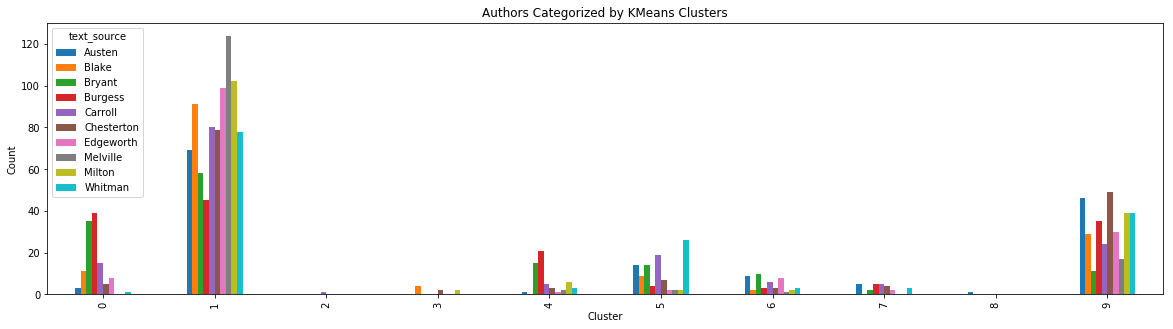

In [200]:
#Show authors categorized by cluster
prediction = pd.crosstab(kmeans_pred, y_train)
prediction.plot(kind='bar', stacked=False, figsize=[20,5])
plt.title('Authors Categorized by Mean Shift Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

In [132]:
#Declare and fit the model
bandwidth = estimate_bandwidth(X_train, quantile=0.3)
meanshift_pred = MeanShift(bandwidth=bandwidth, bin_seeding=True).fit_predict(X_train)

#Print cross tab of data vs prediction
print('Comparing Mean Shift Clusters to Authors:')
print(pd.crosstab(y_train, meanshift_pred))

Comparing Mean Shift Clusters to Authors:
col_0         0   1   2   3   4   5   6   7   8   9   10  11  12  13  14
text_source                                                             
Austen       148   0   0   0   0   0   0   0   0   0   0   0   0   0   0
Blake        145   0   0   0   0   0   0   0   0   0   0   1   0   0   0
Bryant       140   0   0   0   3   0   0   0   2   0   0   0   0   0   0
Burgess      148   0   0   0   0   3   0   0   0   0   0   1   0   0   0
Carroll      152   0   0   0   0   0   0   0   0   0   0   2   1   0   0
Chesterton   150   0   0   1   0   0   1   0   0   0   0   0   0   0   0
Edgeworth    148   0   0   0   0   0   0   1   0   0   0   1   0   0   0
Melville     146   0   0   0   0   0   0   0   0   0   0   0   0   0   0
Milton       153   0   0   0   0   0   0   0   0   0   0   0   0   0   0
Whitman      142   2   1   0   0   0   0   0   0   1   2   3   0   1   1


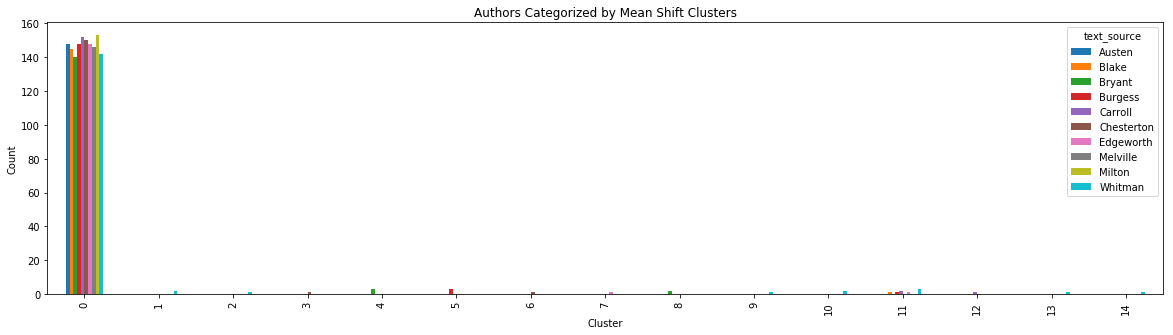

In [201]:
#Show authors categorized by cluster
prediction = pd.crosstab(meanshift_pred, y_train)
prediction.plot(kind='bar', stacked=False, figsize=[20,5])
plt.title('Authors Categorized by Mean Shift Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

In [133]:
#Declare and fit the model.
spectral_pred = SpectralClustering(n_clusters=10).fit_predict(X_train)

#Print cross tab of data vs prediction
print('Comparing Spectral Clusters to Authors:')
print(pd.crosstab(y_train, spectral_pred))

Comparing Spectral Clusters to Authors:
col_0         0   1   2  3    4  5  6  7   8  9
text_source                                    
Austen       18   1   2  0  114  0  0  0  13  0
Blake        13   2   6  0  116  2  0  0   7  0
Bryant       24   4   8  4   95  0  4  2   2  2
Burgess      18   0   4  0  126  0  0  0   4  0
Carroll      12   8   3  0  121  0  0  0  11  0
Chesterton    8   2   2  0  134  0  0  0   6  0
Edgeworth     7   5   1  0  132  0  0  0   5  0
Melville      6  25  21  0   82  0  0  0  12  0
Milton       10   1   5  0  131  0  0  0   6  0
Whitman      13   5   9  0  113  0  0  0  13  0


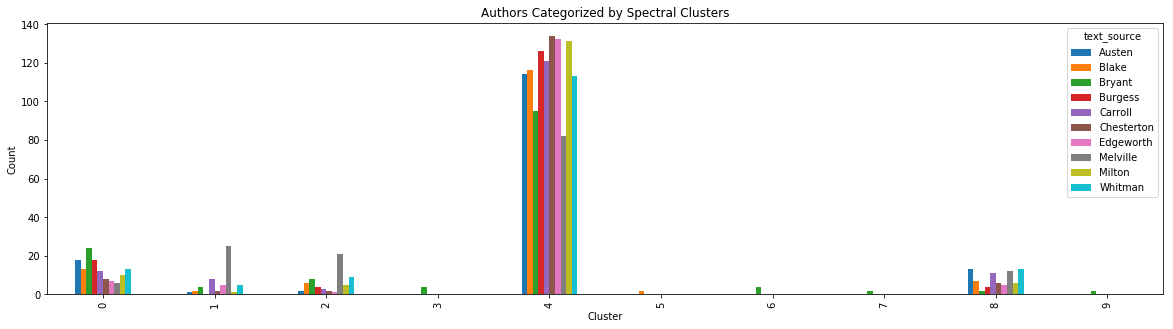

In [202]:
#Show authors categorized by cluster
prediction = pd.crosstab(spectral_pred, y_train)
prediction.plot(kind='bar', stacked=False, figsize=[20,5])
plt.title('Authors Categorized by Spectral Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

In [134]:
#Declare and fit the model.
affinity_pred = AffinityPropagation().fit_predict(X_train)

#Print cross tab of data vs prediction
print('Comparing Affinity Propagation Clusters to Authors:')
print(pd.crosstab(y_train, affinity_pred))

Comparing Affinity Propagation Clusters to Authors:
col_0        0    1    2    3    4    5    6    7    8    9   ...   275  276  \
text_source                                                   ...              
Austen         0    0    1    0    0    0    2    0    0    1 ...     0    0   
Blake          3    0    2    0    0    2    4    0    0    0 ...     0    0   
Bryant         0    1    3    1    5    0    0    0    0    0 ...     0    0   
Burgess        0    0    3    0    0    1    1    0    1    0 ...     0    0   
Carroll        5    0    0    0    0    3    6    0    0    0 ...     0    1   
Chesterton     2    0    3    0    0    4    4    1    0    0 ...     0    0   
Edgeworth      1    0    2    0    0    2    2    0    0    0 ...     0    0   
Melville       3    0    2    0    0    0    0    0    0    0 ...     0    0   
Milton         2    0    1    0    0    0    2    0    0    0 ...     1    0   
Whitman        2    0    1    0    0    1    1    0    0    0 ...   

After attempting several different clustering techniques (KMeans, Mean Shift, Spectral and Affinity) the best performing method was KMeans, although no method was very effective in classifying by author.

# Now, undergo unsupervised feature engineering then run feature set through supervised algorithms

In [135]:
#Create vectorizer model in order to get tf-idf for each sentence

vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=False, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )

#Take pandas series (text_sentence), convert from spacy object to string
sentence_list = word_counts['text_sentence'].astype(str)
print(type(sentence_list))

#Pass pandas series to our vectorizer model
text_tfidf = vectorizer.fit_transform(sentence_list)
print(type(text_tfidf))

<class 'pandas.core.series.Series'>
<class 'scipy.sparse.csr.csr_matrix'>


In [136]:
#List of features
terms = vectorizer.get_feature_names()

#Shape
n = text_tfidf.shape[0]

#A list of dictionaries, one per paragraph
tfidf_bysent = [{} for _ in range(0,n)]

#for each sentence, lists the feature words and their tf-idf scores
for i, j in zip(*text_tfidf.nonzero()):
    tfidf_bysent[i][terms[j]] = text_tfidf[i, j]

#Show first dictionary
display(tfidf_bysent[3])
print(type(tfidf_bysent))

{'Emma': 0.2645973182373566,
 'Miss': 0.2430755193420512,
 'Mr': 0.2015094491250963,
 'Taylor': 0.2602655909020008,
 'Woodhouse': 0.2999255303562577,
 'daughters': 0.34355578238251283,
 'family': 0.29124407675640623,
 'fond': 0.31055077084293076,
 'friend': 0.28061883626973316,
 'governess': 0.34355578238251283,
 'particularly': 0.33293054189583976,
 'years': 0.2562952783300025}

<class 'list'>


In [137]:
#Create dataframe for this feature set
tfidf_df = pd.DataFrame(columns=terms)
tfidf_df['text_sentence'] = word_counts['text_sentence']
tfidf_df['text_source'] = word_counts['text_source']
tfidf_df.loc[:, terms] = 0

In [138]:
counter = 0
for i in tfidf_bysent:
    for k, v in i.items():
        tfidf_df.loc[counter, k] = v
    counter = counter + 1

In [219]:
#First, establish X and Y
Y = tfidf_df['text_source']
X = tfidf_df.drop(['text_sentence','text_source'], 1)

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y,
                                                    test_size=0.25,
                                                    random_state=0)

In [142]:
#Find the right parameters for our supervised models

def tuned_params(model):
    
    if model == 'Random Forest':
                random_forest = np.arange(100, 500, 100)
                random_forest_df = pd.DataFrame()
                for i in random_forest:
                    rfc = ensemble.RandomForestClassifier(n_estimators=i)
                    rfc.fit(X, Y)
                    positive_pred = rfc.predict(X)
                    cross_val = cross_val_score(rfc, X, Y, cv=5).mean()*100
                    score = rfc.score(X, Y)*100
                    random_forest_df_temp = pd.DataFrame({'estimators': i, 'training': score, 'test': cross_val}, index=[0])
                    random_forest_df = random_forest_df.append(random_forest_df_temp)
                plt.plot(random_forest_df['estimators'], random_forest_df['training'], color = 'r', linewidth = 3, label='Training')
                plt.plot(random_forest_df['estimators'], random_forest_df['test'], color = 'b', linewidth = 3, label='Test')
                plt.xlabel('Estimators Parameter', fontsize=20)
                plt.title('Random Forest - Training vs. Test')
                plt.show()
        
    elif model == 'Lasso':
                lasso = np.arange(0.2, 1.0, 0.2)
                lasso_df = pd.DataFrame()
                for i in lasso:
                    lr_lasso = LogisticRegression(penalty='l1', C=i)
                    lr_lasso.fit(X, Y)
                    positive_pred = lr_lasso.predict(X)
                    cross_val = cross_val_score(lr_lasso, X, Y, cv=5).mean()*100
                    score = lr_lasso.score(X, Y)*100
                    lasso_df_temp = pd.DataFrame({'C': i, 'training': score, 'test': cross_val}, index=[0])
                    lasso_df = lasso_df.append(lasso_df_temp)
                plt.plot(lasso_df['C'], lasso_df['training'], color = 'r', linewidth = 3, label='Training')
                plt.plot(lasso_df['C'], lasso_df['test'], color = 'b', linewidth = 3, label='Test')
                plt.xlabel('C Parameter', fontsize=20)
                plt.title('Lasso - Training vs. Test')
                plt.show()
            
    elif model == 'Ridge':
                ridge = np.arange(1, 5001, 1000)
                ridge_df = pd.DataFrame()
                for i in ridge:
                    lr_ridge = LogisticRegression(C=i)
                    lr_ridge.fit(X, Y)
                    positive_pred = lr_ridge.predict(X)
                    cross_val = cross_val_score(lr_ridge, X, Y, cv=5).mean()*100
                    score = lr_ridge.score(X, Y)*100
                    ridge_df_temp = pd.DataFrame({'C': i, 'training': score, 'test': cross_val}, index=[0])
                    ridge_df = ridge_df.append(ridge_df_temp)
                plt.plot(ridge_df['C'], ridge_df['training'], color = 'r', linewidth = 3, label='Training')
                plt.plot(ridge_df['C'], ridge_df['test'], color = 'b', linewidth = 3, label='Test')
                plt.xlabel('C Parameter', fontsize=20)
                plt.title('Ridge - Training vs. Test')
                plt.show()
                
    else:
                svc = np.arange(0.2, 1.0, 0.2)
                svc_df = pd.DataFrame()
                for i in svc:
                    svm = SVC(C=i)
                    svm.fit(X, Y)
                    positive_pred = svm.predict(X)
                    cross_val = cross_val_score(svm, X, Y, cv=5).mean()*100
                    score = svm.score(X, Y)*100
                    svc_df_temp = pd.DataFrame({'C': i, 'training': score, 'test': cross_val}, index=[0])
                    svc_df = svc_df.append(svc_df_temp)
                plt.plot(svc_df['C'], svc_df['training'], color = 'r', linewidth = 3, label='Training')
                plt.plot(svc_df['C'], svc_df['test'], color = 'b', linewidth = 3, label='Test')
                plt.xlabel('C Parameter', fontsize=20)
                plt.title('SVC - Training vs. Test', fontsize=30)
                plt.show()

** Regular Logistic Regression **

In [207]:
#Instantiate and fit
lr = LogisticRegression(penalty='l2', C=1e9)
train = lr.fit(X_train, y_train)

#Scoring
print('Training set score:', lr.score(X_train, y_train))
print('\nTest set score:', lr.score(X_test, y_test))

cross_val = cross_val_score(lr, X, Y, cv=5)
print('\nCross-Validation:', cross_val)

Training set score: 0.9706666666666667

Test set score: 0.668

Cross-Validation: [0.615  0.5975 0.6075 0.64   0.535 ]


** Lasso Logistic Regression **

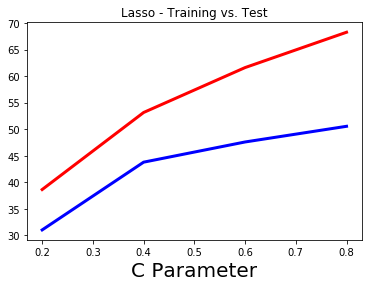

In [208]:
tuned_params('Lasso')

In [209]:
#Instantiate and fit
lr_lasso = LogisticRegression(penalty='l1')
train = lr_lasso.fit(X_train, y_train)

#Scoring
print('Training set score:', lr_lasso.score(X_train, y_train))
print('\nTest set score:', lr_lasso.score(X_test, y_test))

cross_val = cross_val_score(lr_lasso, X, Y, cv=5)
print('\nCross-Validation:', cross_val)

Training set score: 0.7073333333333334

Test set score: 0.548

Cross-Validation: [0.5    0.4925 0.5425 0.575  0.495 ]


** Ridge Logistic Regression **

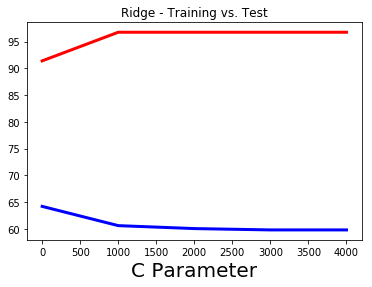

In [210]:
tuned_params('Ridge')

In [211]:
#Instantiate and fit
lr_ridge = LogisticRegression(penalty='l2', C=0.5)
train = lr_ridge.fit(X_train, y_train)

#Scoring
print('Training set score:', lr_ridge.score(X_train, y_train))
print('\nTest set score:', lr_ridge.score(X_test, y_test))

cross_val = cross_val_score(lr_ridge, X, Y, cv=5)
print('\nCross-Validation:', cross_val)

Training set score: 0.902

Test set score: 0.71

Cross-Validation: [0.6225 0.6275 0.6525 0.6775 0.58  ]


** Support Vector Classifier **

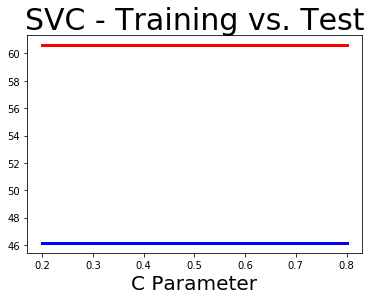

In [212]:
tuned_params('SVM')

In [149]:
#Instantiate and fit
svc = SVC()
train = svc.fit(X_train, y_train)

#Scoring
print('Training set score:', svc.score(X_train, y_train))
print('\nTest set score:', svc.score(X_test, y_test))

cross_val = cross_val_score(svc, X, Y, cv=5)
print('\nCross-Validation:', cross_val)

Training set score: 0.10333333333333333

Test set score: 0.09

Cross-Validation: [0.4375 0.375  0.46   0.5425 0.4925]


** Random Forest Classifier **

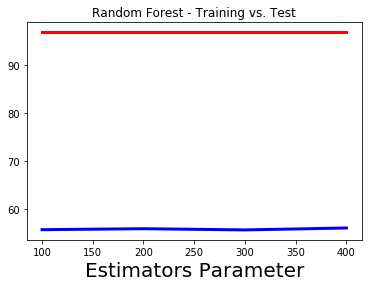

In [213]:
tuned_params('Random Forest')

In [214]:
#Instantiate and fit
rfc = ensemble.RandomForestClassifier(n_estimators=200)
train = rfc.fit(X_train, y_train)

#Scoring
print('Training set score:', rfc.score(X_train, y_train))
print('\nTest set score:', rfc.score(X_test, y_test))

cross_val = cross_val_score(rfc, X, Y, cv=5)
print('\nCross-Validation:', cross_val)

Training set score: 0.9706666666666667

Test set score: 0.634

Cross-Validation: [0.565  0.55   0.5575 0.63   0.52  ]


# Return to Hold Out Group and Cluster based on Unsupervised Features

In [220]:
#Declare and fit the model using 10 clusters for our 10 authors
kmeans_pred = KMeans(n_clusters=10, random_state=42).fit_predict(X_test)

#Print cross tab of data vs prediction
print('Comparing K-Means Clusters to Authors:')
print(pd.crosstab(y_test, kmeans_pred))

Comparing K-Means Clusters to Authors:
col_0         0  1  2   3   4   5  6   7  8  9
text_source                                   
Austen       19  4  0   3   3   5  2  12  2  2
Blake        21  2  4   2   0   4  2  17  0  2
Bryant       13  0  3  18   1   3  5  10  0  2
Burgess      18  1  0   4   2  13  0   6  3  1
Carroll      10  1  0   7  11   3  2   8  0  3
Chesterton   28  1  0   2   1   0  2   6  8  0
Edgeworth    17  7  1   8   3   7  0   7  0  0
Melville     27  2  4   1   1   1  0  18  0  0
Milton       24  2  0   0   1   2  2  15  0  1
Whitman      19  2  0   0   0   5  4  17  0  0


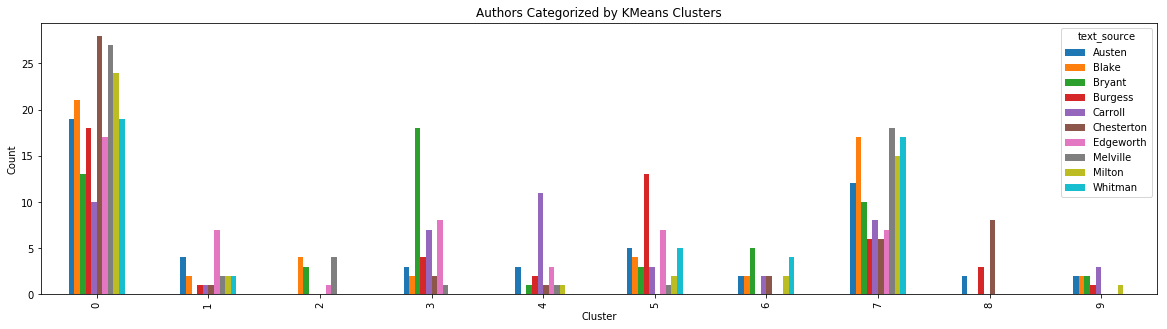

In [221]:
#Show authors categorized by cluster
prediction = pd.crosstab(kmeans_pred, y_test)
prediction.plot(kind='bar', stacked=False, figsize=[20,5])
plt.title('Authors Categorized by KMeans Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

**Let's use some dimension reduction in order to improve our models (SVD)**

In [222]:
#First, establish X and Y
Y = tfidf_df['text_source']
X = tfidf_df.drop(['text_sentence','text_source'], 1)

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y,
                                                    test_size=0.25,
                                                    random_state=0)

In [223]:
for i in range(100, 2400, 100):
    svd = TruncatedSVD(i)
    lsa = make_pipeline(svd, Normalizer(copy=False))
    X_train_lsa = lsa.fit_transform(X_train)
    variance_explained = svd.explained_variance_ratio_
    total_variance = variance_explained.sum()
    print("Percent variance captured by {} components: {}".format(i, total_variance*100))

Percent variance captured by 100 components: 29.934426057662456
Percent variance captured by 200 components: 45.862676656142185
Percent variance captured by 300 components: 57.66703426490386
Percent variance captured by 400 components: 67.054548531374
Percent variance captured by 500 components: 74.74036147192965
Percent variance captured by 600 components: 81.12082249358788
Percent variance captured by 700 components: 86.32470420316693
Percent variance captured by 800 components: 90.5059454719052
Percent variance captured by 900 components: 93.77616622780985
Percent variance captured by 1000 components: 96.25794377788448
Percent variance captured by 1100 components: 98.03804855636902
Percent variance captured by 1200 components: 99.20493650835395
Percent variance captured by 1300 components: 99.83302711116006
Percent variance captured by 1400 components: 99.99999999999997
Percent variance captured by 1500 components: 100.00000000000003
Percent variance captured by 1600 components: 100

**Based on the above, let's change our feature space to 500 (75% explained variance) and see if that impacts our clusters**

In [224]:
svd = TruncatedSVD(500)
lsa = make_pipeline(svd, Normalizer(copy=False))
X_train_lsa = lsa.fit_transform(X_train)
X_test_lsa = lsa.fit_transform(X_test)

In [225]:
#Declare and fit the model using 10 clusters for our 10 authors
kmeans_pred = KMeans(n_clusters=10, random_state=42).fit_predict(X_test_lsa)

#Print cross tab of data vs prediction
print('Comparing K-Means Clusters to Authors:')

prediction = pd.crosstab(y_test, kmeans_pred)
print(prediction)

Comparing K-Means Clusters to Authors:
col_0        0   1  2   3   4  5  6  7   8   9
text_source                                   
Austen       3   1  1   4   5  0  2  2  20  14
Blake        3   0  2  12   1  4  3  2  26   1
Bryant       4   1  1   4  17  3  7  2  15   1
Burgess      4  15  0   2   2  0  4  1  19   1
Carroll      5   1  0   3   6  0  3  3  18   6
Chesterton   6   0  2   2   3  0  1  0  23  11
Edgeworth    5   4  0   4  13  1  2  0  14   7
Melville     6   0  0   7   1  4  3  0  28   5
Milton       6   0  2  11   2  0  2  1  23   0
Whitman      5   1  3  12   1  0  3  0  20   2


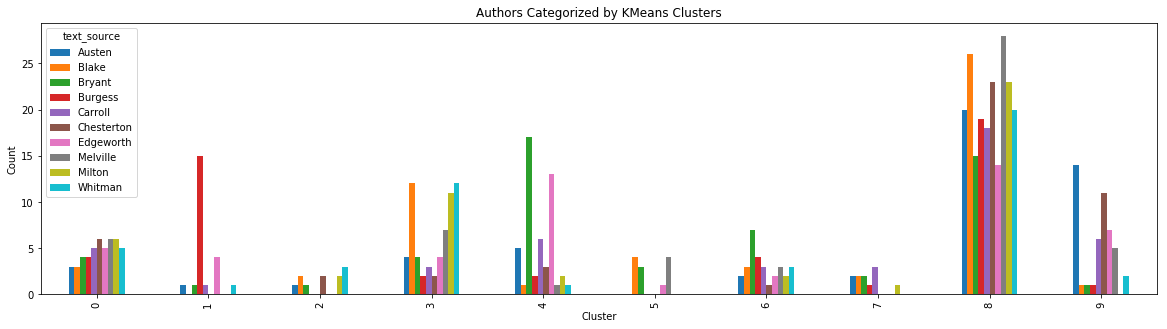

In [226]:
#Show authors categorized by cluster
prediction = pd.crosstab(kmeans_pred, y_test)
prediction.plot(kind='bar', stacked=False, figsize=[20,5])
plt.title('Authors Categorized by KMeans Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

# Conclusion - Clustering vs. Supervised Models

Overall, it seems that the supervised models were much better at classifying authors than the clustering methods. In particular, the Ridge Logistic Regression model performed consistently near 60% at a baseline of 10%. The best cluster I achieved was after using SVD to reduce demensionality. 